# Example of a 90° twisted nematic liquid crystal

Author: O. Castany, M. Müller

Consider the following situation:
- twisted liquid crystal with 90° twist between z=0 and z=d
- liquid crystal aligned along x at z=0.
- input and output polarizers aligned parallel to x

Gooch-Tarry law gives: T_pp = sin²(pi/2·√(1+u²)) / (1+u²),
with u = 2dΔn/λ.
The transmission minima are given by u = ((2m)²-1)^{-1/2} = √(3),√(15),√(35),…

We consider a birefringence Δn = 0.10 and a thickness d = 4.33 µm. The first
minimum should be at λ = 500 nm, or k0 = 1.257e7 m⁻¹.

Note: Gooch-Tarry law does not take into account interferences between the two
glass substrates. A glass with n = 1.55 minimizes the interferences.

In [1]:
import elli
import elli.plot as elliplot
import matplotlib.pyplot as plt
import numpy as np
from numpy.lib.scimath import sqrt
from scipy.constants import c, pi

## Materials

The liquid crystal is sandwiched between two isotropic glass substrates. We choose a refractive index of n = 1.55 for the glass.

The liquid crystal is a uniaxial material with an ordinary refractive index (n_o) and an extraordinary refractive index (n_e).

In [2]:
# Materials
glass = elli.IsotropicMaterial(elli.ConstantRefractiveIndex(1.55))
front = back = glass

# Liquid crystal material
(no, ne) = (1.5, 1.6)
Dn = ne - no
LC = elli.UniaxialMaterial(
    elli.ConstantRefractiveIndex(no), elli.ConstantRefractiveIndex(ne)
)

# By default, the extraordinary axis is along z. We rotate it to be along x.
R = elli.rotation_v_theta(elli.E_Y, 90)
LC.set_rotation(R)

## Structure

We create the twisted nematic layer using elli.TwistedLayer. We specify the material (LC), the total thickness (d), and the total twist angle (90°). The continuous helical twist is approximated by a series of discrete, rotated sub-layers. The number of these sub-layers is set by the divisions parameter.

In [3]:
d = 4330 # Layer thickness in nm
TN = elli.TwistedLayer(LC, d, 7, 90)

# The final structure is the twisted nematic layer between the two glass substrates.
s = elli.Structure(front, [TN], back)

## Calculation Range

We define the spectral range for our simulation. The calculations will be performed over a list of wavenumbers (k0_list), which are then converted to wavelengths (lbda_list) for plotting and theoretical calculations.

In [4]:
# Wavelength range in meters
(lbda_min, lbda_max) = (200e-9, 1)

# Create a list of wavenumbers with even spacing
k0_list = np.linspace(2 * pi / lbda_max, 2 * pi / lbda_min)

# Convert to nm for calculations
lbda_list = (2 * pi) / k0_list * 1e9

## Calculate theoretical curve with Gooch-Tarry law

Before running the full simulation, we calculate the expected transmission using the Gooch-Tarry law. This analytical formula describes the transmission of linearly polarized light through a TN cell placed between parallel polarizers.

In [5]:
u = 2 * d * Dn / lbda_list
GT = np.sin(pi / 2 * sqrt(1 + u**2)) ** 2 / (1 + u**2)

## Run the pyElli Simulation

We now use pyElli's 4x4 Berreman matrix solver to simulate the transmission. To test for numerical convergence, we run the simulation twice: once with a coarse approximation of the twist (7 divisions) and a second time with a finer one (18 divisions). We expect the result with more divisions to be more accurate. This theoretical curve will serve as a benchmark for our simulation.

In [6]:
TN.set_divisions(7)
data = s.evaluate(lbda_list, 0)
T7 = np.real(data.T_pp)

TN.set_divisions(18)
data2 = s.evaluate(lbda_list, 0)
T18 = np.real(data2.T_pp)

## Plot and Compare Results

Finally, we plot the theoretical Gooch-Tarry curve and overlay the results from our two simulations. This visualization allows us to directly compare the numerical results against the analytical solution.

The plot clearly shows that the simulation with 18 divisions matches the theoretical law almost perfectly. The simulation with only 7 divisions shows noticeable deviation, demonstrating that a sufficient number of sub-layers is crucial for accurately modeling the continuously twisted structure.

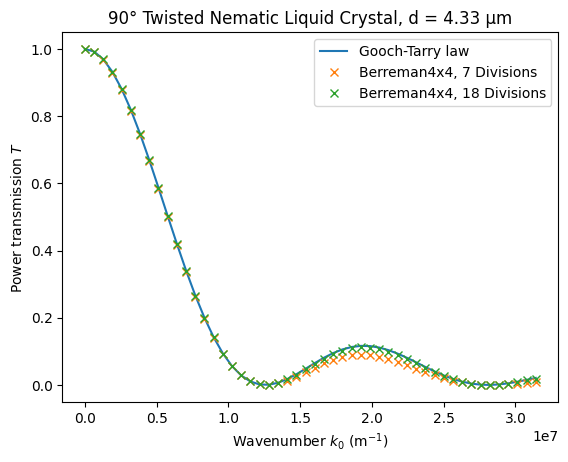

In [7]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot Gooch-Tarry law, for comparison
ax.plot(k0_list, GT, label="Gooch-Tarry law")

# Two plots are made, with 7 or 18 divisions in the TwistedMaterial
ax.plot(k0_list, T7, "x", label="Berreman4x4, 7 Divisions")
ax.plot(k0_list, T18, "x", label="Berreman4x4, 18 Divisions")

ax.set_title("90° Twisted Nematic Liquid Crystal, " + "d = {:.2f} µm".format(d * 1e-3))
ax.set_xlabel(r"Wavenumber $k_0$ (m$^{-1}$)")
ax.set_ylabel(r"Power transmission $T$")
ax.legend()
plt.show()

## Visualize the Modeled Structure

We can also visualize the discretized structure that pyElli uses for the calculation. Below are the representations for both the 7-division and 18-division models. Each segment represents a thin, uniformly oriented sub-layer.

<Axes: xlabel='z (nm)', ylabel="n'">

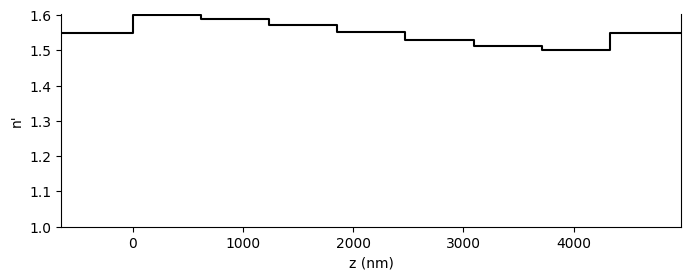

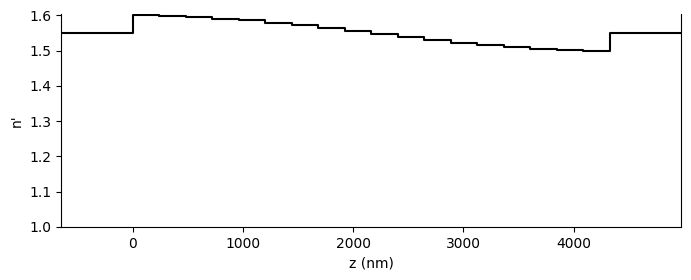

In [8]:
TN.set_divisions(7)
elliplot.draw_structure(s)
TN.set_divisions(18)
elliplot.draw_structure(s)